In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from dal_toolbox.utils import seed_everything

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

INFO:root:test


### Open Questions

* Why is the average loss increasing when increasing the batch_size?
    * Seems not to be a problem in general, but for hyperparameter optimization, this is a crucial point!
    * Sadly dividing by the projection dimensionality does not help.
* What are optimal hyperparameters for noise, batch_size and number of epochs trained?
    * The original paper suggests that training longer and with a bigger batch_size is always beneficial as well as strong augmentations.
    * Strong augmentations in our case make samples indistinguishable, so it is questional if this method would benefit from it.
* How can we determin a clear advantage over random initialization on two dimensional data?

In [2]:
# Testing Cross Entropy Loss for different projection dimensions

n_samples = 10000
ce_loss = nn.CrossEntropyLoss()
for batch_size in [4, 8, 16, 32, 64, 128, 256]:
    X = torch.randn((batch_size, batch_size-1)).float()
    y = torch.randint(0, batch_size-1, (batch_size,)).long()
    loss = ce_loss(X, y)
    print(f"Batch_Size: ",batch_size,"  \t Average CE-Loss:",loss)

Batch_Size:  4   	 Average CE-Loss: tensor(0.7562)
Batch_Size:  8   	 Average CE-Loss: tensor(2.4277)
Batch_Size:  16   	 Average CE-Loss: tensor(2.9513)
Batch_Size:  32   	 Average CE-Loss: tensor(3.9681)
Batch_Size:  64   	 Average CE-Loss: tensor(4.8181)
Batch_Size:  128   	 Average CE-Loss: tensor(5.3945)
Batch_Size:  256   	 Average CE-Loss: tensor(6.0633)


In [3]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None, feature_extractor=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    if feature_extractor:
        feature_extractor.eval()
        feature_extractor.cpu()
        zz = feature_extractor(zz)
    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=15)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [4]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [5]:
class SimCLR(object):
    def __init__(self, **kwargs):
        self.device = kwargs['device']
        self.model = kwargs['model'].to(self.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.n_epochs = kwargs['n_epochs']
        self.batch_size = kwargs['batch_size']
        self.fp16_precision = kwargs['fp16_precision']
        self.temperature = kwargs['temperature']
        self.n_views = kwargs['n_views']
        self.log_every_n_steps = kwargs['log_every_n_steps']
        self.writer = SummaryWriter()
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        # assert similarity_matrix.shape == (
        #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
        # assert similarity_matrix.shape == labels.shape

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=self.fp16_precision)

        n_iter = 0
        logging.info(f"Start SimCLR training for {self.n_epochs} epochs.")
        logging.info(f"Training with gpu: {self.device == 'cuda'}.")

        for epoch_counter in tqdm(range(self.n_epochs)):
            for images, _ in train_loader:
                images = torch.cat(images, dim=0)

                images = images.to(self.device)

                with autocast(enabled=self.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % self.log_every_n_steps == 0:
                    top1 = accuracy(logits, labels, topk=(1,))
                    self.writer.add_scalar('loss', loss, global_step=n_iter)
                    self.writer.add_scalar('acc/top1', top1[0].item(), global_step=n_iter)
                    self.writer.add_scalar('learning_rate', self.scheduler.get_last_lr()[0], global_step=n_iter)

                    logging.info(f"Epoch: {epoch_counter}\tLoss: {round(loss.item(), 2)}\tTop1 accuracy: {round(top1[0].item(), 2)}")

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            
        logging.info("Training has finished.")

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 2, feature_dim: int = 128):
        super(Net, self).__init__()
        self.base_encoder = nn.Sequential(nn.Linear(2, feature_dim), nn.ReLU())
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x, get_features=False):
        feat = self.base_encoder(x)
        if get_features:
            return feat 
        else:
            return self.fc(feat)
        
class NetSimCLR(nn.Module):
    def __init__(self, feature_dim, proj_dim):
        super(NetSimCLR, self).__init__()
        self.backbone = Net(num_classes=proj_dim, feature_dim=feature_dim)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def forward(self, x):
        return self.backbone(x)

In [7]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 1):
    return X + torch.randn_like(X)*noise

class SSLDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets, noise):
        self.tensors = [data, targets]
        self.noise = noise

    def __getitem__(self, idx):
        X, y = [t[idx] for t in self.tensors]
        return [stochasitc_augmentation(X, self.noise), stochasitc_augmentation(X, self.noise)], y
    
    def __len__(self):
        return self.tensors[0].shape[0]

In [8]:
def build_dataset(n_samples, test_set_size=100, ds_noise=0.05, aug_noise=0.05, seed=42):
    assert n_samples > test_set_size, "Test Set is a sub-sample of n_samples"
    X, y = datasets.make_moons(n_samples, noise=ds_noise, random_state=seed)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()

    random.seed(seed)
    test_indices = random.sample(range(X.shape[0]), k = test_set_size)
    train_indices = [i for i in range(X.shape[0]) if i not in test_indices]
    train_ds = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    ssl_ds = SSLDataset(X[train_indices], y[train_indices], noise=aug_noise)
    test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_ds, ssl_ds, test_ds

In [9]:
seed_everything(42)

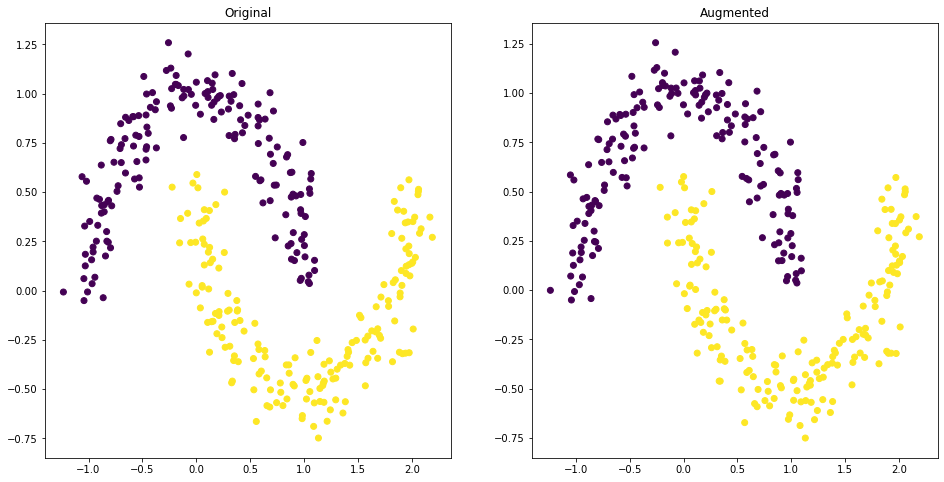

In [10]:
train_ds, ssl_ds, test_ds = build_dataset(n_samples=450, test_set_size=100, ds_noise=0.1, aug_noise=0.005, seed=42)
fix, ax = plt.subplots(1, 2, figsize=(16,8))
X_aug, y_aug = ssl_ds[range(len(ssl_ds))]
ax[0].scatter(train_ds.tensors[0][:,0], train_ds.tensors[0][:,1], c=train_ds.tensors[1])
ax[0].set_title("Original")
ax[1].scatter(X_aug[0][:,0], X_aug[0][:,1], c=y_aug)
ax[1].set_title("Augmented")
plt.show()

In [11]:
batch_size = 64
n_epochs = 200
proj_dim = 16

train_loader = torch.utils.data.DataLoader(
    ssl_ds, batch_size=batch_size, shuffle=True,
    num_workers=1, pin_memory=True, drop_last=True
)

model = NetSimCLR(feature_dim=128, proj_dim=proj_dim)

optimizer = torch.optim.Adam(model.parameters(), 1e-1, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                        last_epoch=-1)

simclr = SimCLR(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    batch_size=batch_size,
    n_epochs=n_epochs,
    fp16_precision=True,
    device='cuda',
    n_views=2,
    temperature=1,
    log_every_n_steps=50
    )
simclr.train(train_loader)

INFO:root:Start SimCLR training for 200 epochs.
INFO:root:Training with gpu: True.


  0%|          | 0/200 [00:00<?, ?it/s]

INFO:root:Epoch: 0	Loss: 4.63	Top1 accuracy: 99.22
INFO:root:Epoch: 10	Loss: 4.11	Top1 accuracy: 96.09
INFO:root:Epoch: 20	Loss: 4.02	Top1 accuracy: 99.22
INFO:root:Epoch: 30	Loss: 4.04	Top1 accuracy: 99.22
INFO:root:Epoch: 40	Loss: 4.04	Top1 accuracy: 98.44
INFO:root:Epoch: 50	Loss: 4.03	Top1 accuracy: 97.66
INFO:root:Epoch: 60	Loss: 4.06	Top1 accuracy: 100.0
INFO:root:Epoch: 70	Loss: 3.98	Top1 accuracy: 99.22
INFO:root:Epoch: 80	Loss: 4.02	Top1 accuracy: 98.44
INFO:root:Epoch: 90	Loss: 3.95	Top1 accuracy: 96.88
INFO:root:Epoch: 100	Loss: 3.95	Top1 accuracy: 96.09
INFO:root:Epoch: 110	Loss: 3.97	Top1 accuracy: 96.88
INFO:root:Epoch: 120	Loss: 3.95	Top1 accuracy: 92.19
INFO:root:Epoch: 130	Loss: 3.99	Top1 accuracy: 98.44
INFO:root:Epoch: 140	Loss: 3.95	Top1 accuracy: 93.75
INFO:root:Epoch: 150	Loss: 3.94	Top1 accuracy: 99.22
INFO:root:Epoch: 160	Loss: 3.95	Top1 accuracy: 98.44
INFO:root:Epoch: 170	Loss: 3.94	Top1 accuracy: 98.44
INFO:root:Epoch: 180	Loss: 3.95	Top1 accuracy: 99.22
INFO

In [21]:
model = Net(num_classes=2, feature_dim=128)
state_dict = simclr.model.state_dict()
device='cuda'
for k in list(state_dict.keys()):
  if k.startswith('backbone.'):
    if k.startswith('backbone') and not k.startswith('backbone.fc'):
      # remove prefix
      state_dict[k[len("backbone."):]] = state_dict[k]
  del state_dict[k]

log = model.load_state_dict(state_dict, strict=False)
assert log.missing_keys == ['fc.weight', 'fc.bias']

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=64, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, shuffle=False, batch_size=64)

# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.Adam(model.parameters(), lr=2e-1, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [22]:
model = model.to(device)
epochs = 100
for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_accuracy += top1[0]
  
  top1_accuracy /= (counter + 1)
  print(f"Epoch {epoch} \tTop1 Train accuracy {round(top1_train_accuracy.item(), 2)}\tTop1 Test accuracy: {round(top1_accuracy.item(), 2)}")

Epoch 0 	Top1 Train accuracy 80.31	Top1 Test accuracy: 84.46
Epoch 1 	Top1 Train accuracy 91.56	Top1 Test accuracy: 94.7
Epoch 2 	Top1 Train accuracy 92.19	Top1 Test accuracy: 95.49
Epoch 3 	Top1 Train accuracy 92.5	Top1 Test accuracy: 95.49
Epoch 4 	Top1 Train accuracy 93.44	Top1 Test accuracy: 92.53
Epoch 5 	Top1 Train accuracy 94.38	Top1 Test accuracy: 92.53
Epoch 6 	Top1 Train accuracy 94.38	Top1 Test accuracy: 94.7
Epoch 7 	Top1 Train accuracy 96.25	Top1 Test accuracy: 97.05
Epoch 8 	Top1 Train accuracy 96.56	Top1 Test accuracy: 97.05
Epoch 9 	Top1 Train accuracy 96.88	Top1 Test accuracy: 97.83
Epoch 10 	Top1 Train accuracy 97.19	Top1 Test accuracy: 97.83
Epoch 11 	Top1 Train accuracy 98.12	Top1 Test accuracy: 97.05
Epoch 12 	Top1 Train accuracy 98.44	Top1 Test accuracy: 97.83
Epoch 13 	Top1 Train accuracy 97.5	Top1 Test accuracy: 97.83
Epoch 14 	Top1 Train accuracy 98.44	Top1 Test accuracy: 97.83
Epoch 15 	Top1 Train accuracy 98.12	Top1 Test accuracy: 97.83
Epoch 16 	Top1 Train a

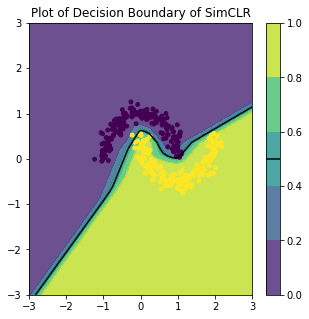

In [23]:
model = model.to("cpu")
fig = plt.figure(figsize=(5, 5))
plt.title("Plot of Decision Boundary of SimCLR")
plot_contour(model, train_ds.tensors[0], train_ds.tensors[1])
plt.show()

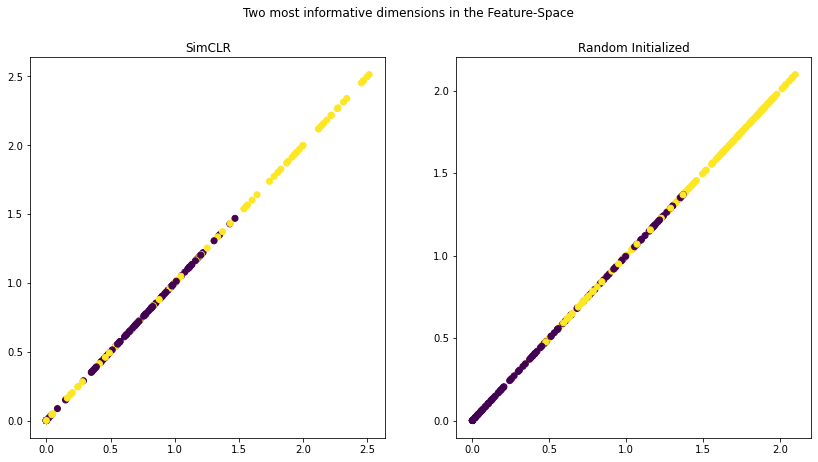

In [15]:
# Forward pass the data through the model and get the features
feat = model(train_ds.tensors[0], get_features=True).detach()

# Find the dimensions of the features with the most highest variance
feat_var = torch.var(feat, dim=0)
topk_var_idx = torch.topk(feat_var, k=2)[1]

# Compare to a random initialized model
baseline = Net(num_classes=2, feature_dim=128)
feat_2 = baseline(train_ds.tensors[0], get_features=True).detach()

# Find the dimensions of the features with the most highest variance
feat_var_2 = torch.var(feat_2, dim=0)
topk_var_idx_2 = torch.topk(feat_var_2, k=2)[1]

# Plot the two dimensions of features with the highest variance
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Two most informative dimensions in the Feature-Space")

ax[0].set_title("SimCLR")
ax[0].scatter(feat[:,topk_var_idx[0]], feat[:,topk_var_idx[0]], c=train_ds.tensors[1])

ax[1].set_title("Random Initialized")
ax[1].scatter(feat_2[:,topk_var_idx_2[0]], feat_2[:,topk_var_idx_2[0]], c=train_ds.tensors[1])
plt.show()

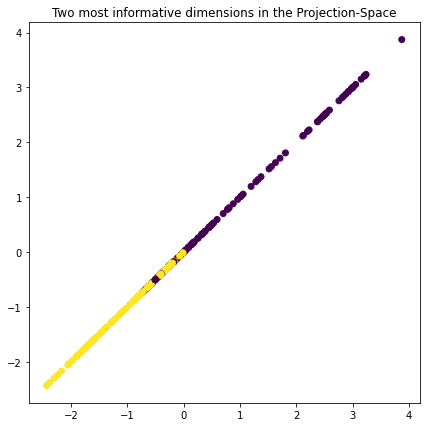

In [16]:
# Forward pass the data through the model and get the projections
simclr.model = simclr.model.to('cpu')
feat = simclr.model(train_ds.tensors[0]).detach()

# Find the dimensions of the features with the most highest variance
feat_var = torch.var(feat, dim=0)
topk_var_idx = torch.topk(feat_var, k=2)[1]

# Plot the two dimensions of features with the highest variance
plt.figure(figsize=(7, 7))
plt.title("Two most informative dimensions in the Projection-Space")
plt.scatter(feat[:,topk_var_idx[0]], feat[:,topk_var_idx[0]], c=train_ds.tensors[1])
plt.show()